# Avoid using events with errors
After chunk the files, checks for errors file by file (group of 100 events)

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

Select the number of file in variable "chnk" for error check

File name: ../data/0.1-0.0k.Wfm.csv - Processing 1/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 2/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 3/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 4/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 5/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 6/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 7/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 8/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 9/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 10/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 11/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 12/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 13/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 14/100 events...
File name: ../data/0.1-0.0k.Wfm.csv - Processing 15/100 events...
File name: ../data/

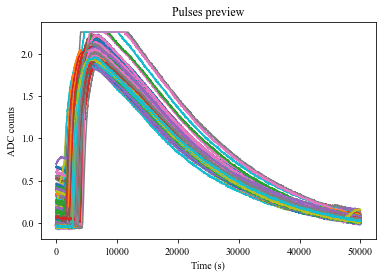

In [15]:
# Check a specific file and check if there are errors

# Inputs:
bas_tot = 1000 # Total number of samples to baseline calculation

# Event processing
# For this test, channels 1 and 3 will be used because the pulses are unipolar
evt_smp = 50000 # Number of samples in an event
evt_acc = 0 # accumulated number of events

for n in range(10): 

    fth_file = "../data/" + str(round(n * 0.1 + 0.1, 1)) + "-" + str(round(n * 0.1, 1)) + "k.Wfm.csv"

    df = pd.read_csv(fth_file, encoding ='utf-8', sep=' ')   
    content = df.values

    # Each column in Numpy array from Pandas data frame     
    y1 = np.array(content[:,1]) # Vertical - Signal 1
    y3 = np.array(content[:,3]) # Vertical - Signal 3

    evt_tot = int(len(df.index)/evt_smp) # Total number of events
    ene_y1 = np.zeros(evt_tot) # Energy for each event in channel 1
    ene_y3 = np.zeros(evt_tot) # Energy for each event in channel 3

    for evt_nb in range(evt_tot):      
        print("File name: {} - Processing {}/{} events...".format(fth_file, evt_nb+1, evt_tot))
        # List of events with problems
        # Avoid these events
        # if chnk == 7:
        #     blc_lst = [45, 46, 47] # chnk = 7
        # if chnk == 17:
        #     blc_lst = [41] # chnk = 17 (see error after this event. It is necessary remove row=4200000)
        # if chnk == 18:
        #     blc_lst = [52, 53] # chnk = 18
        # if chnk == 19:
        #     blc_lst = [98] # chnk = 19 (pileup?)
        # if evt_nb in blc_lst:
        #     print("File name: {} - Skipping {}/{} events...".format(fth_file, evt_nb+1, evt_tot))
        #     continue

        evt_sta = evt_nb * evt_smp # Event start
        evt_end = evt_sta + evt_smp - 1 # Event end
        evt_rng = range(evt_sta, evt_end) # Event range

        plt.plot(y1[evt_rng], label="Channel 1") # Plot channel 1
        plt.plot(y3[evt_rng], label="Channel 3") # Plot channel 3
        plt.xlabel('Time (s)')
        plt.ylabel('ADC counts')
        title = 'Pulses preview'
        plt.title(title)
        #plt.legend()

        # Baseline calculation - Average Moving Method
        # In the Average Moving Method, the average is calculated from the beginning 
        # of the event to the sample referring to the trigger.
        # But for simplification, the average will be calculated up to bas_tot sample 
        
        bas_y1 = np.mean(y1[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 1
        bas_y3 = np.mean(y3[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 3    
        
        # Threshold calculation 
        # For simplification the threshold will be estimed in 6 sigmas aprox.
        thr_y1 = bas_y1 + 6 * np.std(y1[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 1
        thr_y3 = bas_y3 + 6 * np.std(y3[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 3

        # Trigger
        trg_s1 = next(y for y in evt_rng if y1[y] > thr_y1) # Trigger sample for channel 1
        trg_s3 = next(y for y in evt_rng if y3[y] > thr_y3) # Trigger sample for channel 3
        trg_y1 = y1[trg_s1] # Trigger value for channel 1
        trg_y3 = y3[trg_s3] # Trigger value for channel 3    

        # Energy calculation
        ene_y1[evt_acc] = sum(y for y in y1[trg_s1:evt_end] if y > thr_y1) # Energy of event for channel 1
        ene_y3[evt_acc] = sum(y for y in y3[trg_s3:evt_end] if y > thr_y3) # Energy of event for channel 3  

        # Select ONLY ONE event to view threshold in leading edge of pulse    
        smp_le_end = 10000 # Select the number of samples in leading edge for preview    
        smp_le_sta = 5000 # Select the number of samples in leading edge for preview    
        evt_sta = evt_nb * evt_smp + smp_le_sta# Event start
        evt_end = evt_sta + smp_le_end - 1 # Event end
        evt_rng = range(evt_sta, evt_end) # Event range

    evt_acc = evt_acc + 1    

    

---
There are two types of error found:
- Error in processing
- Graphical error

For 'Error in processing' it is necessary to exclude these events.

For 'Graphic Error' the event can be excluded for processing or rebuilt.

Errors in processing are eliminated with the code below: 

```python
if chnk == 7:
    blc_lst = [45, 46, 47] 
if chnk == 17:
    blc_lst = [41] 
if chnk == 18:
    blc_lst = [52, 53] 
if chnk == 19:
    blc_lst = [98]
```
where 'chnk' is the file number and the number in 'blc_lst' (blocked list) is the event to avoid

However, errors in plots can be observed in figure above.

Run the cell above with the file number and below with the event to identify the cause of the error:

File name: ../results/test_17.csv - Processing 41/100 event...
4000000


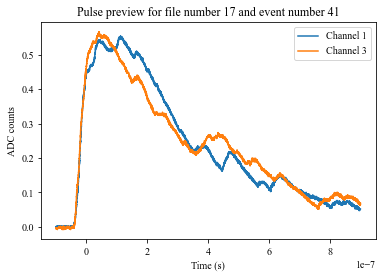

In [36]:
## Verify the event that causes error:

evt_tot = int(len(df.index)/evt_smp) # Total number of events

#Inputs:
evt_nb = 40 # Event index (0-99)

print("File name: {} - Processing {}/{} event...".format(fth_file, evt_nb+1, evt_tot))
evt_smp = 100000 # Number of samples in an event
evt_sta = evt_nb * evt_smp # Event start
evt_end = evt_sta + evt_smp - 1 # Event end
print(evt_sta)
evt_rng = range(evt_sta, evt_end) # Event range

plt.plot(x0[evt_rng], y1[evt_rng], label="Channel 1") # Plot channel 1
plt.plot(x0[evt_rng], y3[evt_rng], label="Channel 3") # Plot channel 3
plt.xlabel('Time (s)')
plt.ylabel('ADC counts')
title = 'Pulse preview for file number '
title1 = ' and event number '
plt.title(title + str(chnk) + title1 + str(evt_nb + 1))
plt.legend()

File name: ../results/test_17.csv - Processing 42/100 event...
4100000


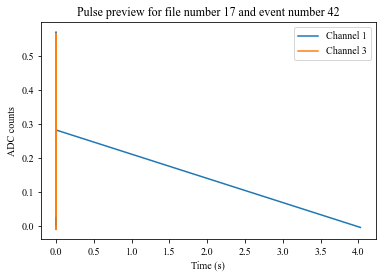

In [37]:
## Verify the event that causes error:

evt_tot = int(len(df.index)/evt_smp) # Total number of events

#Inputs:
evt_nb = 41 # Event index (0-99)

print("File name: {} - Processing {}/{} event...".format(fth_file, evt_nb+1, evt_tot))
evt_smp = 100000 # Number of samples in an event
evt_sta = evt_nb * evt_smp # Event start
evt_end = evt_sta + evt_smp - 1 # Event end
print(evt_sta)
evt_rng = range(evt_sta, evt_end) # Event range

plt.plot(x0[evt_rng], y1[evt_rng], label="Channel 1") # Plot channel 1
plt.plot(x0[evt_rng], y3[evt_rng], label="Channel 3") # Plot channel 3
plt.xlabel('Time (s)')
plt.ylabel('ADC counts')
title = 'Pulse preview for file number '
title1 = ' and event number '
plt.title(title + str(chnk) + title1 + str(evt_nb + 1))
plt.legend()

File name: ../results/test_17.csv - Processing 43/100 event...
4200000


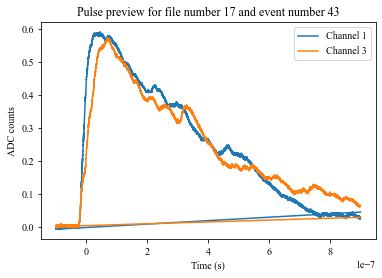

In [38]:
## Verify the event that causes error:

evt_tot = int(len(df.index)/evt_smp) # Total number of events

#Inputs:
evt_nb = 42 # Event index (0-99)

print("File name: {} - Processing {}/{} event...".format(fth_file, evt_nb+1, evt_tot))
evt_smp = 100000 # Number of samples in an event
evt_sta = evt_nb * evt_smp # Event start
evt_end = evt_sta + evt_smp - 1 # Event end
print(evt_sta)
evt_rng = range(evt_sta, evt_end) # Event range

plt.plot(x0[evt_rng], y1[evt_rng], label="Channel 1") # Plot channel 1
plt.plot(x0[evt_rng], y3[evt_rng], label="Channel 3") # Plot channel 3
plt.xlabel('Time (s)')
plt.ylabel('ADC counts')
title = 'Pulse preview for file number '
title1 = ' and event number '
plt.title(title + str(chnk) + title1 + str(evt_nb + 1))
plt.legend()

As can be seen in the example above, in file number 17, even event 41 is ok. Event 42 has a problem which generates errors in the following events due to a sample shift.

Run the cell below **just 1 time** and the shift issue will be fixed and the csv files will change permanently.

In [39]:
## Run this cell just 1 time and the shift issue will be fixed and the csv files will change permanently.

# Inputs:
chnk = 17 # Number of file

fth_file = "../results/test_" + str(chnk) + ".csv"
df = pd.read_csv(fth_file)    

# chnk=17 and row=4200000 -> Time value is shifted for this event, because event index=41 is an event error
if chnk == 17:
    df.drop([df.index[4200000]], inplace=True)
    df.to_csv(fth_file, index=False)
if chnk == 18:
    df.drop([df.index[0]], inplace=True)
    df.to_csv(fth_file, index=False)
if chnk == 19:
     df.drop([df.index[0]], inplace=True)
     df.to_csv(fth_file, index=False)
if chnk == 20:
     df.drop([df.index[0]], inplace=True)
     df.to_csv(fth_file, index=False)
if chnk == 21:
     df.drop([df.index[0]], inplace=True)
     df.to_csv(fth_file, index=False)
if chnk == 22:
     df.drop([df.index[0]], inplace=True)
     df.to_csv(fth_file, index=False)
if chnk == 23:
     df.drop([df.index[0]], inplace=True)
     df.to_csv(fth_file, index=False)

Run the second cell again and verify that the errors are fixed (see the figure below and compare with the first):

File name: ../results/test_17.csv - Processing 1/99 events...
File name: ../results/test_17.csv - Processing 2/99 events...
File name: ../results/test_17.csv - Processing 3/99 events...
File name: ../results/test_17.csv - Processing 4/99 events...
File name: ../results/test_17.csv - Processing 5/99 events...
File name: ../results/test_17.csv - Processing 6/99 events...
File name: ../results/test_17.csv - Processing 7/99 events...
File name: ../results/test_17.csv - Processing 8/99 events...
File name: ../results/test_17.csv - Processing 9/99 events...
File name: ../results/test_17.csv - Processing 10/99 events...
File name: ../results/test_17.csv - Processing 11/99 events...
File name: ../results/test_17.csv - Processing 12/99 events...
File name: ../results/test_17.csv - Processing 13/99 events...
File name: ../results/test_17.csv - Processing 14/99 events...
File name: ../results/test_17.csv - Processing 15/99 events...
File name: ../results/test_17.csv - Processing 16/99 events...
F

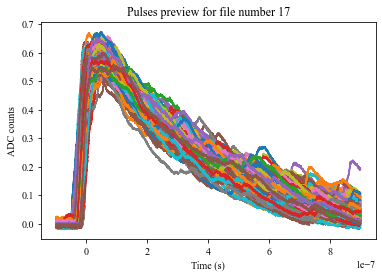

In [40]:
# Check a specific file and check if there are errors

# Inputs:
bas_tot = 1000 # Total number of samples to baseline calculation
chnk = 17 # Number of file

# Event processing
# For this test, channels 1 and 3 will be used because the pulses are unipolar
evt_smp = 100000 # Number of samples in an event
evt_acc = 0 # accumulated number of events

fth_file = "../results/test_" + str(chnk) + ".csv"
df = pd.read_csv(fth_file)    
content = df.values

# Each column in Numpy array from Pandas data frame     
x0 = np.array(content[:,0]) # Horizontal scale -> T = 0.001E-08 (-5.000E-08 - -4.999E-08) 
#y0 = np.array(content[:,1]) # Vertical - Signal 0
y1 = np.array(content[:,2]) # Vertical - Signal 1
#y2 = np.array(content[:,3]) # Vertical - Signal 2
y3 = np.array(content[:,4]) # Vertical - Signal 3

evt_tot = int(len(df.index)/evt_smp) # Total number of events
ene_y1 = np.zeros(evt_tot) # Energy for each event in channel 1
ene_y3 = np.zeros(evt_tot) # Energy for each event in channel 3

for evt_nb in range(evt_tot):      
    print("File name: {} - Processing {}/{} events...".format(fth_file, evt_nb+1, evt_tot))
    # List of events with problems
    # Avoid these events
    if chnk == 7:
        blc_lst = [45, 46, 47] # chnk = 7
    if chnk == 17:
        blc_lst = [41] # chnk = 17 (see error after this event. It is necessary remove row=4200000)
    if chnk == 18:
        blc_lst = [52, 53] # chnk = 18
    if chnk == 19:
        blc_lst = [98] # chnk = 19 (pileup?)
    if evt_nb in blc_lst:
        print("File name: {} - Skipping {}/{} events...".format(fth_file, evt_nb+1, evt_tot))
        continue

    evt_sta = evt_nb * evt_smp # Event start
    evt_end = evt_sta + evt_smp - 1 # Event end
    evt_rng = range(evt_sta, evt_end) # Event range

    plt.plot(x0[evt_rng], y1[evt_rng], label="Channel 1") # Plot channel 1
    plt.plot(x0[evt_rng], y3[evt_rng], label="Channel 3") # Plot channel 3
    plt.xlabel('Time (s)')
    plt.ylabel('ADC counts')
    title = 'Pulses preview for file number '
    plt.title(title + str(chnk))
    #plt.legend()

    # Baseline calculation - Average Moving Method
    # In the Average Moving Method, the average is calculated from the beginning 
    # of the event to the sample referring to the trigger.
    # But for simplification, the average will be calculated up to bas_tot sample 
    
    bas_y1 = np.mean(y1[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 1
    bas_y3 = np.mean(y3[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 3    
    
    # Threshold calculation 
    # For simplification the threshold will be estimed in 6 sigmas aprox.
    thr_y1 = bas_y1 + 6 * np.std(y1[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 1
    thr_y3 = bas_y3 + 6 * np.std(y3[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 3

    # Trigger
    trg_s1 = next(y for y in evt_rng if y1[y] > thr_y1) # Trigger sample for channel 1
    trg_s3 = next(y for y in evt_rng if y3[y] > thr_y3) # Trigger sample for channel 3
    trg_y1 = y1[trg_s1] # Trigger value for channel 1
    trg_y3 = y3[trg_s3] # Trigger value for channel 3
    trg_x1 = x0[trg_s1] # Trigger time for channel 1
    trg_x3 = x0[trg_s3] # Trigger time for channel 3

    # Energy calculation
    ene_y1[evt_acc] = sum(y for y in y1[trg_s1:evt_end] if y > thr_y1) # Energy of event for channel 1
    ene_y3[evt_acc] = sum(y for y in y3[trg_s3:evt_end] if y > thr_y3) # Energy of event for channel 3  

    # Select ONLY ONE event to view threshold in leading edge of pulse    
    smp_le_end = 10000 # Select the number of samples in leading edge for preview    
    smp_le_sta = 5000 # Select the number of samples in leading edge for preview    
    evt_sta = evt_nb * evt_smp + smp_le_sta# Event start
    evt_end = evt_sta + smp_le_end - 1 # Event end
    evt_rng = range(evt_sta, evt_end) # Event range

    evt_acc = evt_acc + 1    

    